# Setup

In [15]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import random
import datetime
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy.linalg import cond
from typing import List

# Matrixkit
import matrixkit
import matrixkit.block as blk
from matrixkit import preconditioning as prec
from matrixkit.core import MatrixData, ValueProperties, BlockProperties

# modellib

import modellib.io as io

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [7]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 2000
DIAGONAL_BAND_RADIUS = 10
RNG_SEED = 42
VALUE_COLORBAR = 'rocket'
BLOCK_COLORBAR = 'flare'

initialized        data vectors of size   2000 x  64 x  64 =   8192000 with a memory usage of  31.250 MiB
initialized  data start vectors of size   2000 x  64       =    128000 with a memory usage of   0.122 MiB
initialized noise start vectors of size   2000 x  64       =    128000 with a memory usage of   0.122 MiB
initialized        band vectors of size   2000 x  64 x  10 =   1280000 with a memory usage of  10.254 MiB
--------------------------------------------------------------------------------
instantiation rng generators...
generating matrices...
invalid matrices: 0
determinant abs-value range: [0.020097101107239723, 3694413.75]


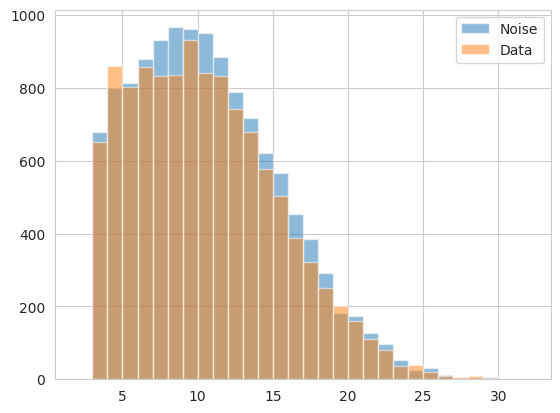

duration: 18.31 seconds


In [8]:
# Generate matrices
bgr_noise_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.0, 0.5))
noise_blk_value_props = ValueProperties(density_range=(0.3, 0.5), value_range=(0.3, 1.0))
noise_blk_block_props = BlockProperties(size_range=(3, 32), size_average=10, size_std_dev=0.66, gap_chance=0.5)
tdata_blk_value_props = ValueProperties(density_range=(0.5, 0.7), value_range=(0.3, 1.0))
tdata_blk_block_props = BlockProperties(size_range=(2, 32), size_average=10, size_std_dev=0.66, gap_chance=0)

test_data = MatrixData(
        dimension=MATRIX_DIM,
        band_radius=DIAGONAL_BAND_RADIUS,
        sample_size=NUMBER_OF_MATRICES,
        background_noise_value_properties=bgr_noise_value_props,
        block_noise_value_properties=noise_blk_value_props,
        block_noise_block_properties=noise_blk_block_props,
        block_data_value_properties=tdata_blk_value_props,
        block_data_block_properties=tdata_blk_block_props,
        seed=42,
        determinant_cutoff=0.01,
        print_debug=True
    )

In [9]:
bands = test_data.bands.reshape(NUMBER_OF_MATRICES, (DIAGONAL_BAND_RADIUS* 2 + 1), MATRIX_DIM, 1)
bands = np.nan_to_num(bands) # replace NaNs with 0s
labels = test_data.tdata_blk_starts
print(f"Matrix Bands Shape: {bands.shape}, Matrix Labels Shape: {labels.shape}")

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

# Create test matrices and labels
test_matrices = test_data.matrices[train_size + val_size:]
test_labels = labels[train_size + val_size:]

# Verify Shape
print(f"Test Matrices Shape: {test_matrices.shape}, Test Labels Shape: {test_labels.shape}")
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Matrix Bands Shape: (2000, 21, 64, 1), Matrix Labels Shape: (2000, 64)
Test Matrices Shape: (200, 64, 64), Test Labels Shape: (200, 64)
Train size: 1600, Val size: 200, Test size: 200


# Save matrices

In [20]:
io.save_to_hdf5(train_dataset, "train_matrices_64_1600.h5")
io.save_to_hdf5(val_dataset, "val_matrices_64_200.h5")
io.save_to_hdf5(test_dataset, "test_matrices_64_200.h5")

# Load matrices

In [19]:
importlib.reload(io)

<module 'modellib.io' from '/home/moonchild/PycharmProjects/preconditioners/modellib/io.py'>

In [21]:
# Reading the datasets
train_bands, train_labels = io.read_from_hdf5("train_matrices_64_1600.h5")
val_bands, val_labels = io.read_from_hdf5("val_matrices_64_200.h5")
test_bands, test_labels = io.read_from_hdf5("test_matrices_64_200.h5")

# Printing shapes to verify
print(f"Train bands shape: {train_bands.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation bands shape: {val_bands.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test bands shape: {test_bands.shape}, Test labels shape: {test_labels.shape}")

Train bands shape: (1600, 21, 64, 1), Train labels shape: (1600, 64)
Validation bands shape: (200, 21, 64, 1), Validation labels shape: (200, 64)
Test bands shape: (200, 21, 64, 1), Test labels shape: (200, 64)
